In [32]:
import cv2
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter


In [33]:
# ============================================================
# Prepair Dataset
# ============================================================

def Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE):
    # Ustvari izhodni direktorij, če še ne obstaja
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Pridobi vse .jpg slike
    image_paths = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR)
                   if f.lower().endswith(('.jpg', '.jpeg'))]

    print(f"Najdenih {len(image_paths)} slik za obdelavo...")

    for path in tqdm(image_paths, desc="Obdelujem slike"):
        # Preberi sliko
        img = cv2.imread(path)
        if img is None:
            print(f"❌ Napaka pri branju slike: {path}")
            continue

        # Pretvori v sivinsko
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Spremeni velikost (320x240)
        resized = cv2.resize(gray, TARGET_SIZE)

        # Ustvari enako ime datoteke v izhodni mapi
        filename = os.path.basename(path)
        output_path = os.path.join(OUTPUT_DIR, filename)

        # Shrani obdelano sliko
        cv2.imwrite(output_path, resized)

    print("✅ Vse slike so uspešno predobdelane in shranjene v:")
    print(f"   {OUTPUT_DIR}")


INPUT_DIR = "datasets/val2017"
PREPROCESSED_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
# Preprocess_and_save_images(INPUT_DIR, OUTPUT_DIR, TARGET_SIZE)


In [34]:
# ============================================================
# HELPER FUNKCIJE ZA GENERIRANJE PAROV
# ============================================================

def sample_window(img_shape, window_size=64, margin=16):
    h, w = img_shape[:2]
    x = random.randint(margin, w - margin - window_size)
    y = random.randint(margin, h - margin - window_size)
    return x, y


def get_corners(x, y, window_size=64):
    return np.array([
        [x, y],
        [x + window_size, y],
        [x + window_size, y + window_size],
        [x, y + window_size]
    ], dtype=np.float32)


def perturb_corners(corners, disp_range=(-16, 16)):
    min_disp, max_disp = disp_range
    disp = np.random.randint(min_disp, max_disp + 1, size=corners.shape).astype(np.float32)
    return corners + disp, disp


def generate_pair(img, window_size=64, margin=16, disp_range=(-16, 16)):
    h, w = img.shape[:2]

    x, y = sample_window((h, w), window_size, margin)

    src_corners = get_corners(x, y, window_size)
    dst_corners, disp = perturb_corners(src_corners, disp_range)
    # print("src_corners: ", src_corners)
    # print("dst_corners: ", dst_corners)
    # print("disp: ", disp)

    # Homografija H (src -> dst) in njen inverz
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp celotne slike z H^-1
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Izreži patche
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Stack v 2 kanala in normaliziraj
    pair = np.stack([orig_patch, warped_patch], axis=-1).astype(np.float32) / 255.0

    # Ground truth: pomiki kotičkov
    offsets = (dst_corners - src_corners).astype(np.float32)
    # print("offsets: ", offsets)

    return pair, offsets, src_corners, warped


In [35]:
# ============================================================
# TEST GENERIRANJA PARA
# ============================================================

def visualize_generate_pair(image_dir):
    # Nalož naključno sliko
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    h, w = img.shape[:2]
    window_size = 64
    margin = 16
    disp_range = (-16, 16)

    # Sample window
    x, y = sample_window((h, w), window_size, margin)

    # Get corners
    src_corners = get_corners(x, y, window_size)
    dst_corners = perturb_corners(src_corners, disp_range)

    # Compute homography
    H = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_inv = np.linalg.inv(H)

    # Warp image
    warped = cv2.warpPerspective(img, H_inv, (w, h), flags=cv2.INTER_LINEAR)

    # Extract patches
    orig_patch = img[y:y + window_size, x:x + window_size]
    warped_patch = warped[y:y + window_size, x:x + window_size]

    # Calculate offsets
    offsets = dst_corners - src_corners

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Original image with source corners
    ax = axes[0, 0]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(src_corners):
        ax.plot(cx, cy, 'go', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='green', fontsize=12, ha='center')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Original Image + Source Corners (green)')
    ax.axis('off')

    # 2. Original image with destination corners
    ax = axes[0, 1]
    ax.imshow(img, cmap='gray')
    for i, (cx, cy) in enumerate(dst_corners):
        ax.plot(cx, cy, 'ro', markersize=10)
        ax.text(cx, cy - 5, f'{i}', color='red', fontsize=12, ha='center')
    # Draw lines showing displacement
    for i in range(4):
        ax.arrow(src_corners[i, 0], src_corners[i, 1],
                 offsets[i, 0], offsets[i, 1],
                 head_width=3, head_length=3, fc='yellow', ec='yellow', alpha=0.7)
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='green', linewidth=2, linestyle='--')
    ax.add_patch(rect)
    ax.set_title(f'Perturbed Corners (red)\nAvg offset: {np.abs(offsets).mean():.1f}px')
    ax.axis('off')

    # 3. Warped image with H^-1
    ax = axes[0, 2]
    ax.imshow(warped, cmap='gray')
    rect = plt.Rectangle((x, y), window_size, window_size, fill=False, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    ax.set_title('Warped Image (H⁻¹ applied)')
    ax.axis('off')

    # 4. Original patch
    ax = axes[1, 0]
    ax.imshow(orig_patch, cmap='gray')
    ax.set_title('Original Patch (64×64)')
    ax.axis('off')

    # 5. Warped patch
    ax = axes[1, 1]
    ax.imshow(warped_patch, cmap='gray')
    ax.set_title('Warped Patch (64×64)')
    ax.axis('off')

    # Hide the 6th subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print offsets
    print("\nCorner offsets (Δx, Δy):")
    for i, (dx, dy) in enumerate(offsets):
        print(f"  Corner {i}: ({dx:+.1f}, {dy:+.1f}) px")


PREPROCESSED_DIR = "datasets/val2017_preprocessed"
# Run visualization
# if os.path.exists(PREPROCESSED_DIR):
#     visualize_generate_pair(PREPROCESSED_DIR)

In [36]:
def visualize_offset_sign(image_dir, window_size=64, margin=16, disp_range=(-16, 16)):
    # Pick random image
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_paths:
        print("❌ No images found in", image_dir)
        return

    img_path = random.choice(image_paths)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Could not read image:", img_path)
        return

    # Generate pair using your pipeline
    pair, offsets, src_corners, warped_true = generate_pair(
        img, window_size=window_size, margin=margin, disp_range=disp_range
    )
    dst_corners = src_corners + offsets

    # Reconstruct warps using both offset signs
    H_plus = cv2.getPerspectiveTransform(src_corners, dst_corners)
    H_minus = cv2.getPerspectiveTransform(src_corners, src_corners - offsets)

    warped_plus = cv2.warpPerspective(img, H_plus, (img.shape[1], img.shape[0]))
    warped_minus = cv2.warpPerspective(img, H_minus, (img.shape[1], img.shape[0]))

    # --- Visualization ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    # 1️⃣ True warped image
    axes[0].imshow(warped_true, cmap='gray')
    axes[0].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2, label='src'))
    axes[0].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='blue', lw=2, label='dst (GT)'))
    axes[0].set_title("True warped image (from generate_pair)")
    axes[0].legend()
    axes[0].axis('off')

    # 2️⃣ Reconstructed with +offsets
    axes[1].imshow(warped_plus, cmap='gray')
    axes[1].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2))
    axes[1].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='red', lw=2))
    axes[1].set_title("Reconstructed warp (+offsets)")
    axes[1].axis('off')

    # 3️⃣ Reconstructed with -offsets
    axes[2].imshow(warped_minus, cmap='gray')
    axes[2].add_patch(plt.Polygon(src_corners, fill=False, edgecolor='green', lw=2))
    axes[2].add_patch(plt.Polygon(dst_corners, fill=False, edgecolor='red', lw=2))
    axes[2].set_title("Reconstructed warp (-offsets)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Numeric comparison for confirmation
    diff_plus = np.mean(np.abs(warped_true.astype(np.float32) - warped_plus.astype(np.float32)))
    diff_minus = np.mean(np.abs(warped_true.astype(np.float32) - warped_minus.astype(np.float32)))

    print(f"Mean pixel difference (true vs +offsets): {diff_plus:.2f}")
    print(f"Mean pixel difference (true vs -offsets): {diff_minus:.2f}")

    if diff_minus < diff_plus:
        print("⚠️ Offsets likely need to be NEGATED during training.")
    else:
        print("✅ Offsets appear to have the correct sign.")

# visualize_offset_sign(PREPROCESSED_DIR)


In [37]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, stride=1,
                 dropout_rate=0.1):
        super(ResNetBlock, self).__init__()
        out_channels = out_channels or in_channels  # če ni določeno, ohrani enako št. kanalov

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)

        out = self.conv1(x)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.dropout(out)
        out += residual

        out = self.relu(out)
        return out


In [38]:
class ResNetBody(nn.Module):
    def __init__(self, in_channels=2, dropout_rate=0.1):
        super(ResNetBody, self).__init__()

        # ----- 1. stopnja -----
        self.layer1 = nn.Sequential(
            ResNetBlock(in_channels, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        # ----- 2. stopnja -----
        self.layer2 = nn.Sequential(
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            ResNetBlock(64, 64, dropout_rate=dropout_rate),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )

        # ----- 3. stopnja -----
        self.layer3 = nn.Sequential(
            ResNetBlock(64, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 16x16 -> 8x8
        )

        # ----- 4. stopnja -----
        self.layer4 = nn.Sequential(
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            ResNetBlock(128, 128, dropout_rate=dropout_rate),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
            # zadnji max pool ni potreben, ohranimo 8x8
        )

        # ----- Polno povezan sloj -----
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 8 * 8, 512)

    def forward(self, x):  # Nx2x64x64
        x = self.layer1(x)  # Nx64x32x32
        x = self.layer2(x)  # Nx64x16x16
        x = self.layer3(x)  # Nx128x8x8
        x = self.layer4(x)  # Nx128x8x8
        x = self.flatten(x)  # Nx8192
        x = self.fc(x)  # Nx512
        return x


In [39]:
class RegressionHead(nn.Module):
    def __init__(self, in_features=512, out_features=8):
        super(RegressionHead, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):  # Nx512
        return self.fc(x)  # Nx8

In [40]:
class ClassificationHead(nn.Module):
    def __init__(self, in_features=512, num_classes=21, class_dim=8):
        super(ClassificationHead, self).__init__()
        self.num_classes = num_classes
        self.class_dim = class_dim
        self.fc = nn.Linear(in_features, num_classes * class_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):  # Nx512
        x = self.fc(x)  # Nx168
        x = x.view(-1, self.num_classes, self.class_dim)  # Nx21x8
        x = self.softmax(x)  # Nx21x8
        return x

In [41]:
class HomographyRegressor(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(HomographyRegressor, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = RegressionHead(in_features=512, out_features=8)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [42]:
class HomographyClassifier(nn.Module):
    def __init__(self, num_classes=21, class_dim=8, dropout_rate=0.1):
        super(HomographyClassifier, self).__init__()
        self.body = ResNetBody(in_channels=2, dropout_rate=dropout_rate)
        self.head = ClassificationHead(in_features=512,
                                       num_classes=num_classes,
                                       class_dim=class_dim)

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

In [53]:
import os
import re


def extract_epoch(filename):
    match = re.search(r"epoch_(\d+)", filename)
    return int(match.group(1)) if match else -1


def nn_train(model, num_epochs, model_file_name, img, optimizer, criterion, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0

    # 🔄 Resume if checkpoint exists
    checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
    checkpoints = sorted(checkpoints, key=extract_epoch)
    if checkpoints:
        latest_ckpt = os.path.join(checkpoint_dir, checkpoints[-1])
        checkpoint = torch.load(latest_ckpt, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"]
        print(f"✅ Resuming from checkpoint: {latest_ckpt} (epoch {start_epoch})")
    else:
        print("🚀 Starting training from scratch.")

    # ✅ TensorBoard logger
    writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, "runs"))

    # 🔁 Training loop with progress bar for epochs
    progress_bar = tqdm(range(start_epoch, num_epochs), desc="Training", ncols=100)

    # pair, offsets, *_ = generate_pair(
    #     img=random.choice(img) if isinstance(img, list) else img,
    #     window_size=64,
    #     margin=16,
    #     disp_range=(-16, 16)
    # )
    # pair = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).to(device).float()  # 1x2x64x64
    # offsets = torch.from_numpy(offsets.flatten()).unsqueeze(0).to(device).float()  # 1x8

    for epoch in progress_bar:
        model.train()

        pair, offsets, *_ = generate_pair(
            img=random.choice(img) if isinstance(img, list) else img,
            window_size=64,
            margin=16,
            disp_range=(-16, 16)
        )

        pair = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).to(device).float()  # 1x2x64x64
        offsets = torch.from_numpy(offsets.flatten()).unsqueeze(0).to(device).float()  # 1x8

        # Forward
        preds = model(pair)
        loss = criterion(preds, -offsets)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 🔹 Log loss to TensorBoard
        rmse = torch.sqrt(loss + 1e-8)
        writer.add_scalar("Loss/RMSE", rmse.item(), epoch)
        with torch.no_grad():
            mae = torch.mean(torch.abs(preds - -offsets))
        writer.add_scalar("Error/MAE", mae.item(), epoch)

        # Update progress bar with current epoch and loss
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs}")
        progress_bar.set_postfix(loss=f"{loss.item():.6f}")

        # 💾 Save checkpoint every 1000 epochs
        if (epoch + 1) % 1000 == 0 or (epoch + 1) == num_epochs:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch + 1}.pth")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, checkpoint_path)
            print(f"\n💾 Saved checkpoint: {checkpoint_path}")

            # 🧹 Keep only last 4 checkpoints
            checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")])
            checkpoints = sorted(checkpoints, key=extract_epoch)
            while len(checkpoints) > 4:
                old_ckpt = os.path.join(checkpoint_dir, checkpoints[0])
                os.remove(old_ckpt)
                print(f"🗑️ Removed old checkpoint: {old_ckpt}")
                checkpoints.pop(0)

    writer.close()
    progress_bar.close()

    # ✅ Save final model
    torch.save(model.state_dict(), model_file_name)
    print(f"✅ Final model saved: {model_file_name}")

    # 🧹 Clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"🧹 GPU memory cleared. Current allocated: {torch.cuda.memory_allocated(device) / 1e9:.2f} GB")


def check_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(device) / 1e9
        reserved = torch.cuda.memory_reserved(device) / 1e9
        total = torch.cuda.get_device_properties(device).total_memory / 1e9
        print(f"GPU Memory Status:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved:  {reserved:.2f} GB")
        print(f"  Total:     {total:.2f} GB")
        print(f"  Free:      {total - reserved:.2f} GB")
    else:
        print("CUDA not available")


def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print("✅ GPU cache cleared")
        check_gpu_memory()
    else:
        print("CUDA not available")

In [54]:
import torch.optim as optim

num_epochs = 50000
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = HomographyRegressor(dropout_rate=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

image_names = [
    "000000002299.jpg",
    # "000000000285.jpg",
    # "000000000632.jpg",
]

images = []
for filename in image_names:
    img_path = os.path.join(PREPROCESSED_DIR, filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        images.append(image)
    else:
        print(f"⚠️ Warning: Could not load {filename}")

print(f"📷 Loaded {len(images)} image(s) for training")

nn_train(
    model=model,
    num_epochs=num_epochs,
    model_file_name=f"h_regressor_ep{num_epochs}_I{len(images)}.pth",
    img=images[0] if len(images) == 1 else images,
    optimizer=optimizer,
    criterion=criterion,
    checkpoint_dir="checkpoints_homography_-O_multiSample"
)

Using device: cuda
📷 Loaded 1 image(s) for training
🚀 Starting training from scratch.


Epoch 1002/50000:   2%|▍                    | 1001/50000 [01:30<1:44:05,  7.85it/s, loss=140.814545]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_1000.pth


Epoch 2002/50000:   4%|▉                     | 2002/50000 [03:02<1:34:57,  8.42it/s, loss=78.315636]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_2000.pth


Epoch 3002/50000:   6%|█▎                    | 3001/50000 [04:21<2:05:28,  6.24it/s, loss=54.522362]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_3000.pth


Epoch 4003/50000:   8%|█▉                      | 4003/50000 [05:31<58:41, 13.06it/s, loss=54.475163]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_4000.pth


Epoch 5002/50000:  10%|██▏                   | 5001/50000 [06:40<1:36:40,  7.76it/s, loss=31.871174]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_5000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_1000.pth


Epoch 6002/50000:  12%|██▌                  | 6001/50000 [08:05<1:28:54,  8.25it/s, loss=103.602562]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_6000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_2000.pth


Epoch 7002/50000:  14%|██▉                  | 7001/50000 [09:29<1:25:48,  8.35it/s, loss=123.879959]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_7000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_3000.pth


Epoch 8003/50000:  16%|███▊                    | 8002/50000 [10:39<58:19, 12.00it/s, loss=47.126648]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_8000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_4000.pth


Epoch 9001/50000:  18%|███▉                  | 9000/50000 [11:59<1:28:27,  7.72it/s, loss=30.031715]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_9000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_5000.pth


Epoch 10002/50000:  20%|████                | 10002/50000 [13:21<1:11:38,  9.30it/s, loss=13.570242]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_10000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_6000.pth


Epoch 11002/50000:  22%|████▌                | 11001/50000 [14:44<1:17:43,  8.36it/s, loss=4.306711]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_11000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_7000.pth


Epoch 12002/50000:  24%|████▊               | 12000/50000 [16:14<1:52:42,  5.62it/s, loss=69.091644]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_12000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_8000.pth


Epoch 13001/50000:  26%|█████▏              | 13001/50000 [17:42<1:27:17,  7.06it/s, loss=52.541756]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_13000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_9000.pth


Epoch 14001/50000:  28%|█████▌              | 14001/50000 [19:09<1:57:13,  5.12it/s, loss=30.556276]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_14000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_10000.pth


Epoch 15002/50000:  30%|██████              | 15002/50000 [20:37<1:03:18,  9.21it/s, loss=18.440853]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_15000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_11000.pth


Epoch 16002/50000:  32%|██████▍             | 16001/50000 [22:04<1:16:13,  7.43it/s, loss=78.833954]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_16000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_12000.pth


Epoch 17002/50000:  34%|██████▊             | 17001/50000 [23:34<1:17:37,  7.08it/s, loss=26.936562]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_17000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_13000.pth


Epoch 18001/50000:  36%|███████▏            | 18001/50000 [24:59<1:21:32,  6.54it/s, loss=14.331364]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_18000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_14000.pth


Epoch 19002/50000:  38%|███████▌            | 19001/50000 [26:28<1:06:34,  7.76it/s, loss=35.286442]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_19000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_15000.pth


Epoch 20001/50000:  40%|████████▍            | 20001/50000 [27:55<1:16:46,  6.51it/s, loss=8.673851]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_20000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_16000.pth


Epoch 21002/50000:  42%|█████████▏            | 21001/50000 [29:21<53:44,  8.99it/s, loss=57.812874]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_21000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_17000.pth


Epoch 22002/50000:  44%|██████████             | 22002/50000 [30:49<51:43,  9.02it/s, loss=7.782095]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_22000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_18000.pth


Epoch 23001/50000:  46%|█████████▏          | 23000/50000 [32:06<1:10:06,  6.42it/s, loss=33.906940]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_23000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_19000.pth


Epoch 24001/50000:  48%|█████████▌          | 24001/50000 [33:33<1:08:36,  6.32it/s, loss=12.538423]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_24000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_20000.pth


Epoch 25002/50000:  50%|███████████           | 25001/50000 [35:01<54:39,  7.62it/s, loss=36.749573]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_25000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_21000.pth


Epoch 26001/50000:  52%|███████████▍          | 26000/50000 [36:29<47:33,  8.41it/s, loss=27.271772]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_26000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_22000.pth


Epoch 27001/50000:  54%|██████████▊         | 27001/50000 [37:57<1:00:37,  6.32it/s, loss=17.120562]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_27000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_23000.pth


Epoch 28001/50000:  56%|████████████▎         | 28001/50000 [39:24<51:46,  7.08it/s, loss=19.261066]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_28000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_24000.pth


Epoch 29002/50000:  58%|████████████▊         | 29001/50000 [40:52<44:46,  7.82it/s, loss=32.168625]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_29000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_25000.pth


Epoch 30002/50000:  60%|█████████████▏        | 30001/50000 [42:17<40:53,  8.15it/s, loss=17.390457]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_30000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_26000.pth


Epoch 31001/50000:  62%|██████████████▎        | 31001/50000 [43:43<46:46,  6.77it/s, loss=7.202311]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_31000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_27000.pth


Epoch 32001/50000:  64%|██████████████        | 32000/50000 [45:08<36:44,  8.17it/s, loss=12.077478]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_32000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_28000.pth


Epoch 33001/50000:  66%|██████████████▌       | 33000/50000 [46:36<33:54,  8.35it/s, loss=10.330656]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_33000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_29000.pth


Epoch 34001/50000:  68%|███████████████▋       | 34001/50000 [48:01<37:50,  7.04it/s, loss=8.177935]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_34000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_30000.pth


Epoch 35002/50000:  70%|████████████████       | 35000/50000 [49:29<37:32,  6.66it/s, loss=9.855230]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_35000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_31000.pth


Epoch 36002/50000:  72%|███████████████▊      | 36001/50000 [50:56<29:09,  8.00it/s, loss=15.810953]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_36000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_32000.pth


Epoch 37002/50000:  74%|████████████████▎     | 37001/50000 [52:22<26:43,  8.11it/s, loss=11.009033]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_37000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_33000.pth


Epoch 38001/50000:  76%|████████████████▋     | 38001/50000 [53:50<27:44,  7.21it/s, loss=11.561756]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_38000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_34000.pth


Epoch 39002/50000:  78%|█████████████████▉     | 39001/50000 [55:17<22:50,  8.02it/s, loss=6.885918]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_39000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_35000.pth


Epoch 40001/50000:  80%|█████████████████▌    | 40000/50000 [56:45<33:31,  4.97it/s, loss=11.700535]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_40000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_36000.pth


Epoch 41001/50000:  82%|██████████████████▊    | 41001/50000 [58:14<18:36,  8.06it/s, loss=3.558885]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_41000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_37000.pth


Epoch 42002/50000:  84%|██████████████████▍   | 42002/50000 [59:40<13:42,  9.73it/s, loss=40.498932]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_42000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_38000.pth


Epoch 43001/50000:  86%|█████████████████▏  | 43000/50000 [1:01:08<14:04,  8.29it/s, loss=13.690475]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_43000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_39000.pth


Epoch 44001/50000:  88%|██████████████████▍  | 44001/50000 [1:02:34<13:13,  7.56it/s, loss=6.069045]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_44000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_40000.pth


Epoch 45002/50000:  90%|██████████████████  | 45001/50000 [1:04:01<12:10,  6.84it/s, loss=38.280422]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_45000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_41000.pth


Epoch 46002/50000:  92%|███████████████████▎ | 46001/50000 [1:05:28<09:17,  7.17it/s, loss=5.478744]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_46000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_42000.pth


Epoch 47002/50000:  94%|███████████████████▋ | 47002/50000 [1:06:56<05:24,  9.23it/s, loss=7.842217]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_47000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_43000.pth


Epoch 48002/50000:  96%|███████████████████▏| 48000/50000 [1:08:22<04:06,  8.12it/s, loss=11.585653]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_48000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_44000.pth


Epoch 49002/50000:  98%|███████████████████▌| 49000/50000 [1:09:50<02:24,  6.90it/s, loss=16.644997]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_49000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_45000.pth


Epoch 50000/50000: 100%|████████████████████| 50000/50000 [1:11:18<00:00, 11.69it/s, loss=30.761932]


💾 Saved checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_50000.pth
🗑️ Removed old checkpoint: checkpoints_homography_-O_multiSample\checkpoint_epoch_46000.pth
✅ Final model saved: h_regressor_ep50000_I1.pth
🧹 GPU memory cleared. Current allocated: 0.40 GB


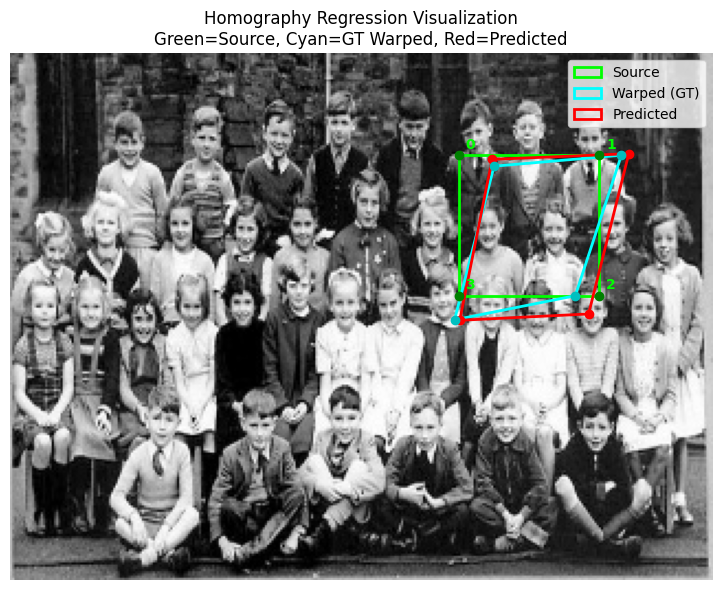

Ground Truth Offsets:
 [[ 16.   5.]
 [ 10.   0.]
 [-11.   0.]
 [ -2.  11.]]
Predicted Offsets:
 [[-15.12  -1.89]
 [-13.37   0.69]
 [  4.94  -8.31]
 [ -0.38 -11.2 ]]
Mean abs error per corner: [18.014  9.522]


In [60]:
def visualize_regression_result(model, image, window_size=64, margin=16, disp_range=(-16, 16),
                                device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()

    # Generate pair from your existing pipeline
    pair, offsets_gt, src_corners, warped_true = generate_pair(
        image, window_size=window_size, margin=margin, disp_range=disp_range
    )
    dst_corners_gt = src_corners + offsets_gt  # ground-truth displaced corners

    # Prepare tensor
    pair_tensor = torch.from_numpy(pair).permute(2, 0, 1).unsqueeze(0).float().to(device)

    # Predict offsets
    with torch.no_grad():
        pred_offsets = model(pair_tensor).cpu().numpy().reshape(4, 2)

    dst_corners_pred = src_corners - pred_offsets  # predicted displaced corners

    # --- Visualization ---
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(image, cmap='gray')

    # Plot polygons: source, GT, predicted
    ax.add_patch(plt.Polygon(src_corners, fill=False, edgecolor='lime', lw=2, label='Source'))
    ax.add_patch(plt.Polygon(dst_corners_gt, fill=False, edgecolor='cyan', lw=2, label='Warped (GT)'))
    ax.add_patch(plt.Polygon(dst_corners_pred, fill=False, edgecolor='red', lw=2, label='Predicted'))

    # Draw corner points and labels
    for i, (x, y) in enumerate(src_corners):
        ax.plot(x, y, 'go', markersize=6)
        ax.text(x + 3, y - 3, str(i), color='lime', fontsize=10, weight='bold')

    for (x, y) in dst_corners_pred:
        ax.plot(x, y, 'ro', markersize=6)

    for (x, y) in dst_corners_gt:
        ax.plot(x, y, 'co', markersize=6)

    ax.legend()
    ax.set_title("Homography Regression Visualization\nGreen=Source, Cyan=GT Warped, Red=Predicted")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Optional: print numeric details
    print("Ground Truth Offsets:\n", np.round(offsets_gt, 2))
    print("Predicted Offsets:\n", np.round(pred_offsets, 2))
    print("Mean abs error per corner:", np.mean(np.abs(pred_offsets - offsets_gt), axis=0).round(3))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
model.load_state_dict(torch.load("checkpoints_homography_-O_multiSample/checkpoint_epoch_50000.pth")["model_state_dict"])
model.eval()

img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
visualize_regression_result(model, img)

